# Feature Importance

## Learning Objectives
By the end of this notebook, you will be able to:
- Understand why feature importance matters
- Calculate and interpret impurity-based feature importance
- Use permutation importance for more reliable estimates
- Compare different importance methods
- Visualize feature importance effectively
- Perform feature selection based on importance
- Apply feature importance to real datasets

## Introduction

**Feature Importance** answers the question: "Which features matter most for predictions?"

**Why does it matter?**
- **Understanding**: Which variables drive the predictions?
- **Debugging**: Are irrelevant features being used?
- **Feature selection**: Remove unimportant features
- **Domain insights**: What patterns did the model find?
- **Communication**: Explain model to stakeholders

**Two main methods**:
1. **Impurity-based importance**: Fast, but can be misleading
2. **Permutation importance**: Slower, but more reliable

## Setup

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# # Try to import XGBoost
# try:
#     import xgboost as xgb
#     XGB_AVAILABLE = True
# except ImportError:
#     XGB_AVAILABLE = False
#     print("XGBoost not available (optional)")

# Set random seed
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Prepare Data

In [5]:
# Load breast cancer dataset
cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [12]:
cancer.filename
#X = cancer.data 

'breast_cancer.csv'

In [9]:
cancer.data

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]], shape=(569, 30))

In [ ]:
#X = cancer.data 
#y = cancer.target

X, y = cancer.data, cancer.target

# Create DataFrame for easier manipulation
df = pd.DataFrame(X, columns=cancer.feature_names)
df['target'] = y
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [ ]:

print("Breast Cancer Wisconsin Dataset")
print("="*60)
print(f"Samples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"Target: {cancer.target_names}")
print(f"\nFeature names:")
for i, name in enumerate(cancer.feature_names):
    print(f"  {i+1:2d}. {name}")

# Show basic statistics
print("\nFirst few samples:")
print(df.head())


Breast Cancer Wisconsin Dataset
Samples: 569
Features: 30
Target: ['malignant' 'benign']

Feature names:
   1. mean radius
   2. mean texture
   3. mean perimeter
   4. mean area
   5. mean smoothness
   6. mean compactness
   7. mean concavity
   8. mean concave points
   9. mean symmetry
  10. mean fractal dimension
  11. radius error
  12. texture error
  13. perimeter error
  14. area error
  15. smoothness error
  16. compactness error
  17. concavity error
  18. concave points error
  19. symmetry error
  20. fractal dimension error
  21. worst radius
  22. worst texture
  23. worst perimeter
  24. worst area
  25. worst smoothness
  26. worst compactness
  27. worst concavity
  28. worst concave points
  29. worst symmetry
  30. worst fractal dimension

First few samples:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0   

In [ ]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

## 2. Impurity-Based Feature Importance

**How it works**:
- Each time a feature is used for a split, it reduces impurity (Gini or entropy)
- Sum up all impurity reductions for each feature across all trees
- Normalize to sum to 1.0

**Advantages**:
- Fast to compute
- Available in scikit-learn by default

**Disadvantages**:
- Biased toward high-cardinality features (many unique values)
- Can be misleading with correlated features
- Based on training data only

In [14]:
# Train a Random Forest
print("Training Random Forest...\n")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

train_acc = rf.score(X_train, y_train)
test_acc = rf.score(X_test, y_test)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Get feature importances
importances = rf.feature_importances_
feature_names = cancer.feature_names

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Impurity-based):")
print(importance_df.head(10).to_string(index=False))

print(f"\nSum of all importances: {importances.sum():.2f}")
print(f"Top 10 features account for: {importance_df.head(10)['importance'].sum():.1%} of total importance")

Training Random Forest...

Training Accuracy: 1.000
Test Accuracy: 0.936

Top 10 Most Important Features (Impurity-based):
             feature  importance
worst concave points    0.158955
          worst area    0.146962
     worst perimeter    0.085793
        worst radius    0.078952
         mean radius    0.077714
      mean perimeter    0.074234
 mean concave points    0.065869
      mean concavity    0.054281
           mean area    0.041657
     worst concavity    0.031362

Sum of all importances: 1.00
Top 10 features account for: 81.6% of total importance


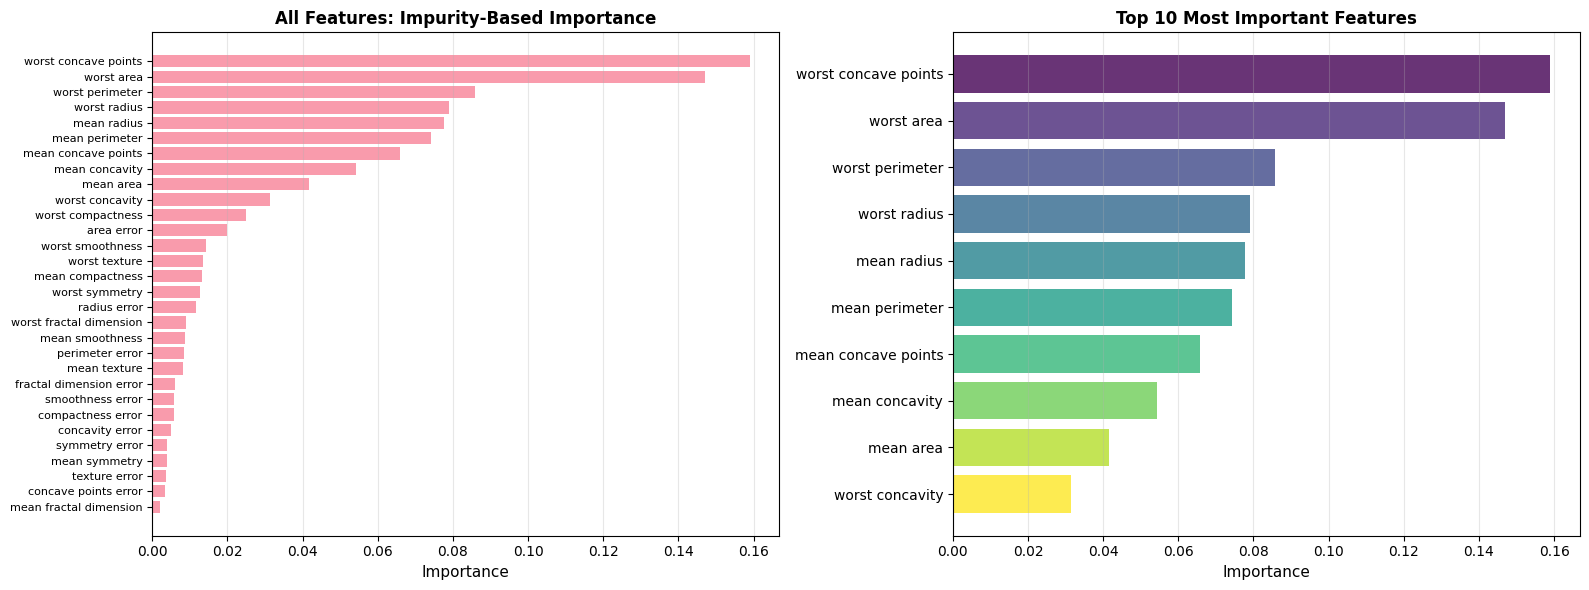

In [15]:
# Visualize feature importances
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All features
ax = axes[0]
sorted_idx = np.argsort(importances)
pos = np.arange(len(sorted_idx))
ax.barh(pos, importances[sorted_idx], alpha=0.7)
ax.set_yticks(pos)
ax.set_yticklabels([feature_names[i] for i in sorted_idx], fontsize=8)
ax.set_xlabel('Importance', fontsize=11)
ax.set_title('All Features: Impurity-Based Importance', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Top 10 features
ax = axes[1]
top_10 = importance_df.head(10).iloc[::-1]  # Reverse for plotting
colors = plt.cm.viridis(np.linspace(0, 1, 10))[::-1]
ax.barh(range(10), top_10['importance'], color=colors, alpha=0.8)
ax.set_yticks(range(10))
ax.set_yticklabels(top_10['feature'], fontsize=10)
ax.set_xlabel('Importance', fontsize=11)
ax.set_title('Top 10 Most Important Features', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Key Insight: Interpreting Results

Looking at the top features:
- **worst perimeter**, **worst concave points**, **worst radius**: These are measurements of the worst (largest) cell
- These features capture the most severe characteristics
- Makes medical sense: Larger, more irregular cells often indicate malignancy

## 3. Permutation Importance

**More reliable alternative**: Permutation importance

**How it works**:
1. Calculate baseline performance on test set
2. For each feature:
   - Randomly shuffle that feature's values
   - Calculate new performance
   - Importance = drop in performance
3. Repeat multiple times for stability

**Advantages**:
- More reliable
- Based on test/validation data
- Not biased toward high-cardinality features
- Model-agnostic (works with any model)

**Disadvantages**:
- Slower (need to retrain/repredict)
- Can be affected by correlated features

In [16]:
# Calculate permutation importance
print("Calculating Permutation Importance...\n")
print("This may take a minute...")

perm_importance = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10,  # Repeat 10 times for stability
    random_state=42,
    n_jobs=-1
)

# Get mean and std
perm_importances_mean = perm_importance.importances_mean
perm_importances_std = perm_importance.importances_std

# Create DataFrame
perm_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importances_mean,
    'std': perm_importances_std
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Permutation):")
print(perm_importance_df.head(10).to_string(index=False))

print(f"\nFeatures with negative importance: {(perm_importances_mean < 0).sum()}")
print("(Negative = shuffling improved performance by chance)")

Calculating Permutation Importance...

This may take a minute...



Top 10 Most Important Features (Permutation):
          feature  importance      std
    worst texture    0.005848 0.000000
     mean texture    0.003509 0.002865
 worst smoothness    0.001754 0.002680
     radius error    0.001754 0.002680
  perimeter error    0.001754 0.002680
   symmetry error    0.000585 0.001754
compactness error    0.000000 0.000000
 smoothness error    0.000000 0.000000
   worst symmetry    0.000000 0.000000
worst compactness    0.000000 0.000000

Features with negative importance: 11
(Negative = shuffling improved performance by chance)


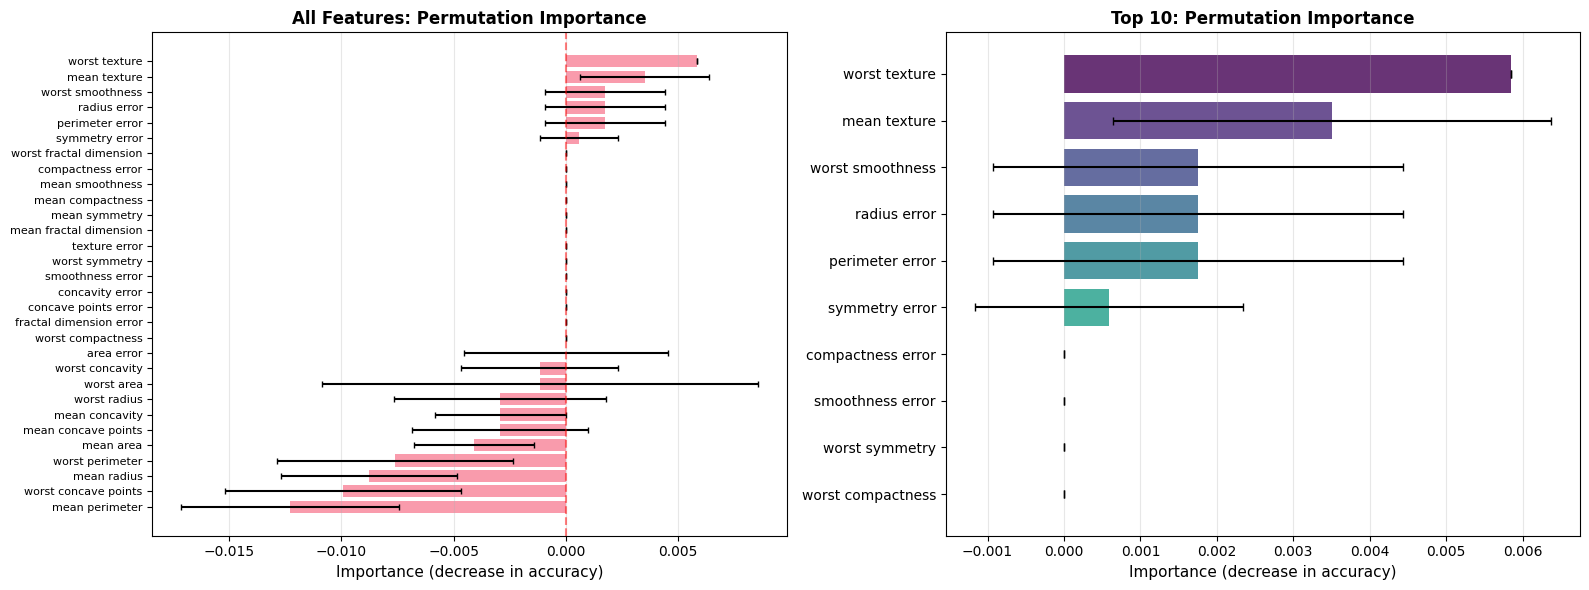

In [17]:
# Visualize permutation importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All features with error bars
ax = axes[0]
sorted_idx = np.argsort(perm_importances_mean)
pos = np.arange(len(sorted_idx))
ax.barh(pos, perm_importances_mean[sorted_idx], 
        xerr=perm_importances_std[sorted_idx], 
        alpha=0.7, capsize=2)
ax.set_yticks(pos)
ax.set_yticklabels([feature_names[i] for i in sorted_idx], fontsize=8)
ax.set_xlabel('Importance (decrease in accuracy)', fontsize=11)
ax.set_title('All Features: Permutation Importance', fontsize=12, fontweight='bold')
ax.axvline(0, color='red', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')

# Top 10 features with error bars
ax = axes[1]
top_10 = perm_importance_df.head(10).iloc[::-1]  # Reverse for plotting
colors = plt.cm.viridis(np.linspace(0, 1, 10))[::-1]
ax.barh(range(10), top_10['importance'], 
        xerr=top_10['std'], 
        color=colors, alpha=0.8, capsize=3)
ax.set_yticks(range(10))
ax.set_yticklabels(top_10['feature'], fontsize=10)
ax.set_xlabel('Importance (decrease in accuracy)', fontsize=11)
ax.set_title('Top 10: Permutation Importance', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 4. Comparing Importance Methods

Let's compare impurity-based and permutation importance side-by-side.

In [18]:
# Compare both methods
comparison_df = pd.DataFrame({
    'feature': feature_names,
    'impurity': importances,
    'permutation': perm_importances_mean
})

# Normalize for comparison
comparison_df['impurity_norm'] = comparison_df['impurity'] / comparison_df['impurity'].sum()
comparison_df['permutation_norm'] = comparison_df['permutation'] / comparison_df['permutation'].sum()

# Sort by impurity importance
comparison_df = comparison_df.sort_values('impurity', ascending=False)

print("Comparison: Impurity vs Permutation Importance")
print("="*70)
print("\nTop 15 features (sorted by impurity importance):")
print(comparison_df[['feature', 'impurity_norm', 'permutation_norm']].head(15).to_string(index=False))

# Calculate correlation
correlation = np.corrcoef(comparison_df['impurity'], comparison_df['permutation'])[0, 1]
print(f"\nCorrelation between methods: {correlation:.3f}")

if correlation > 0.7:
    print("High correlation: Both methods largely agree")
elif correlation > 0.4:
    print("Moderate correlation: Some differences between methods")
else:
    print("Low correlation: Methods disagree significantly")

Comparison: Impurity vs Permutation Importance

Top 15 features (sorted by impurity importance):
             feature  impurity_norm  permutation_norm
worst concave points       0.158955      2.575758e-01
          worst area       0.146962      3.030303e-02
     worst perimeter       0.085793      1.969697e-01
        worst radius       0.078952      7.575758e-02
         mean radius       0.077714      2.272727e-01
      mean perimeter       0.074234      3.181818e-01
 mean concave points       0.065869      7.575758e-02
      mean concavity       0.054281      7.575758e-02
           mean area       0.041657      1.060606e-01
     worst concavity       0.031362      3.030303e-02
   worst compactness       0.024985     -0.000000e+00
          area error       0.019936      8.629461e-16
    worst smoothness       0.014164     -4.545455e-02
       worst texture       0.013599     -1.515152e-01
    mean compactness       0.013177     -0.000000e+00

Correlation between methods: -0.706
Lo

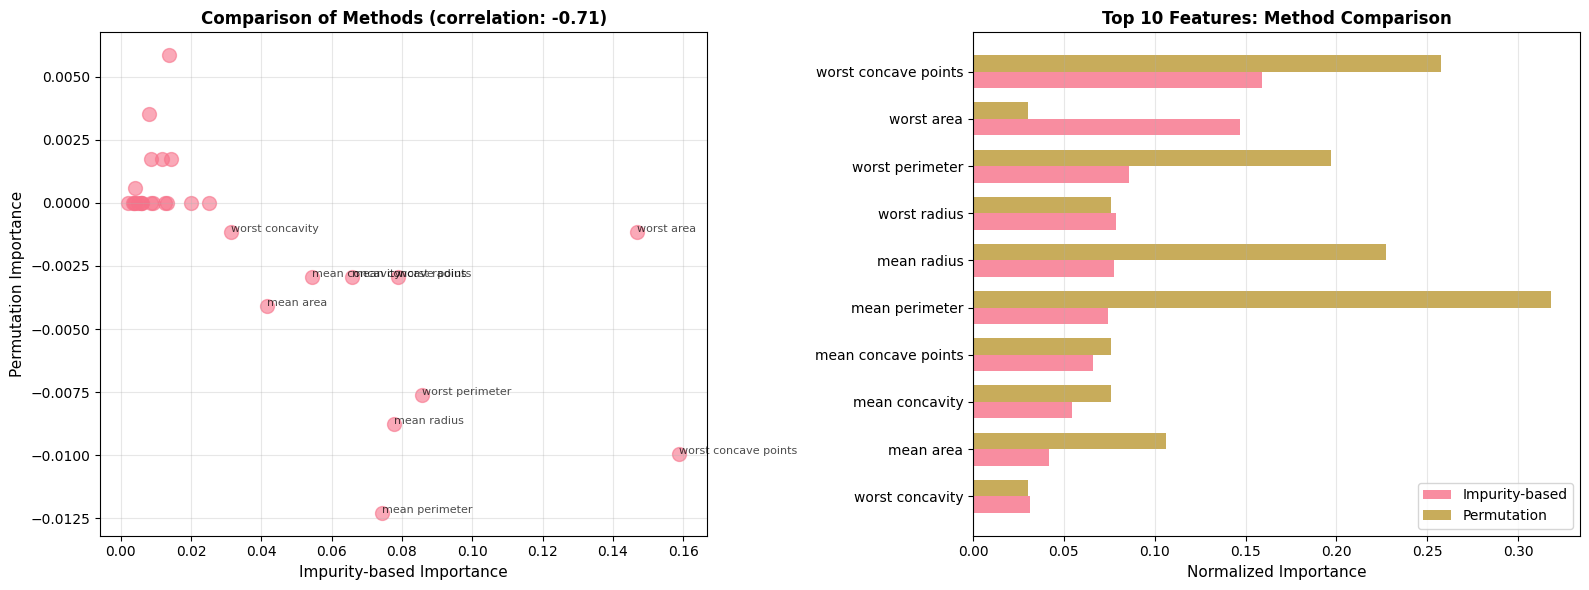

In [19]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax = axes[0]
ax.scatter(comparison_df['impurity'], comparison_df['permutation'], 
          alpha=0.6, s=100)

# Add feature labels for top features
top_features = comparison_df.head(10)
for idx, row in top_features.iterrows():
    ax.annotate(row['feature'], 
               (row['impurity'], row['permutation']),
               fontsize=8, alpha=0.7)

ax.set_xlabel('Impurity-based Importance', fontsize=11)
ax.set_ylabel('Permutation Importance', fontsize=11)
ax.set_title(f'Comparison of Methods (correlation: {correlation:.2f})', 
            fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Side-by-side bar chart for top 10
ax = axes[1]
top_10_comp = comparison_df.head(10).iloc[::-1]  # Reverse for plotting
y_pos = np.arange(10)
width = 0.35

ax.barh(y_pos - width/2, top_10_comp['impurity_norm'], width, 
       label='Impurity-based', alpha=0.8)
ax.barh(y_pos + width/2, top_10_comp['permutation_norm'], width, 
       label='Permutation', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_10_comp['feature'], fontsize=10)
ax.set_xlabel('Normalized Importance', fontsize=11)
ax.set_title('Top 10 Features: Method Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Key Insight: Which Method to Use?

**Use Impurity-based when**:
- You need fast results
- For initial exploration
- Features are not highly correlated

**Use Permutation importance when**:
- You need reliable estimates
- For final analysis
- When features might be correlated
- For model-agnostic importance

**Best practice**: Use both and compare!

## 5. Feature Importance Across Different Models

Different models might find different features important. Let's compare.

In [ ]:
# Train multiple models
print("Training multiple models...\n")

models = [
    ('Decision Tree', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, random_state=42)),
]

if XGB_AVAILABLE:
    models.append(('XGBoost', xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)))

importance_dict = {}

for name, model in models:
    model.fit(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    # Get importances
    importances = model.feature_importances_
    importance_dict[name] = importances
    
    print(f"{name:20s}: Test Acc = {test_acc:.3f}")

# Create DataFrame
importance_comparison = pd.DataFrame(importance_dict, index=feature_names)

print("\n\nTop 10 features for each model:")
print("="*70)
for model_name in importance_comparison.columns:
    top_features = importance_comparison[model_name].nlargest(10)
    print(f"\n{model_name}:")
    for i, (feature, imp) in enumerate(top_features.items(), 1):
        print(f"  {i:2d}. {feature:30s} {imp:.4f}")

In [ ]:
# Visualize importance across models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, model_name in enumerate(importance_comparison.columns):
    ax = axes[idx]
    
    # Get top 15 features
    top_15 = importance_comparison[model_name].nlargest(15).iloc[::-1]
    
    colors = plt.cm.viridis(np.linspace(0, 1, 15))[::-1]
    ax.barh(range(15), top_15.values, color=colors, alpha=0.8)
    ax.set_yticks(range(15))
    ax.set_yticklabels(top_15.index, fontsize=9)
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 6. Feature Selection Based on Importance

We can use feature importance for **feature selection**: Remove unimportant features to:
- Reduce overfitting
- Speed up training
- Simplify the model
- Improve interpretability

In [ ]:
# Try different numbers of features
n_features_to_try = [5, 10, 15, 20, 30]

print("Testing different numbers of top features:\n")

results = []

# Get feature importance from Random Forest
rf_full = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_full.fit(X_train, y_train)
importances = rf_full.feature_importances_

# Baseline: all features
baseline_acc = rf_full.score(X_test, y_test)
print(f"Baseline (all {X.shape[1]} features): {baseline_acc:.4f}")

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]

for n_features in n_features_to_try:
    # Select top n features
    top_indices = sorted_indices[:n_features]
    
    X_train_selected = X_train[:, top_indices]
    X_test_selected = X_test[:, top_indices]
    
    # Train model
    rf_selected = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_selected.fit(X_train_selected, y_train)
    
    test_acc = rf_selected.score(X_test_selected, y_test)
    
    results.append({
        'n_features': n_features,
        'test_acc': test_acc,
        'acc_diff': test_acc - baseline_acc
    })
    
    print(f"Top {n_features:2d} features: {test_acc:.4f} (diff: {test_acc - baseline_acc:+.4f})")

results_df = pd.DataFrame(results)

# Find optimal number
best_n = results_df.loc[results_df['test_acc'].idxmax(), 'n_features']
best_acc = results_df['test_acc'].max()

print(f"\nBest result: {int(best_n)} features (accuracy: {best_acc:.4f})")
print(f"\nWith just {int(best_n)} features ({int(best_n)/X.shape[1]*100:.0f}% of original), "
      f"we achieved {best_acc:.4f} accuracy!")

In [ ]:
# Visualize feature selection results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs number of features
ax = axes[0]
ax.plot(results_df['n_features'], results_df['test_acc'], 
        'o-', linewidth=2, markersize=10)
ax.axhline(baseline_acc, color='red', linestyle='--', 
          label=f'Baseline (all features): {baseline_acc:.4f}')
ax.axvline(best_n, color='green', linestyle='--', alpha=0.5,
          label=f'Best: {int(best_n)} features')
ax.set_xlabel('Number of Features', fontsize=11)
ax.set_ylabel('Test Accuracy', fontsize=11)
ax.set_title('Feature Selection: Accuracy vs Number of Features', 
            fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Accuracy difference
ax = axes[1]
colors = ['green' if x >= 0 else 'red' for x in results_df['acc_diff']]
ax.bar(results_df['n_features'], results_df['acc_diff'], 
      color=colors, alpha=0.7)
ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Number of Features', fontsize=11)
ax.set_ylabel('Accuracy Difference from Baseline', fontsize=11)
ax.set_title('Performance Change with Feature Selection', 
            fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Show the selected top features
n_selected = int(best_n)
top_features_indices = sorted_indices[:n_selected]
top_features_names = feature_names[top_features_indices]
top_features_importance = importances[top_features_indices]

print(f"\nSelected Top {n_selected} Features:")
print("="*60)
for i, (name, imp) in enumerate(zip(top_features_names, top_features_importance), 1):
    print(f"{i:2d}. {name:35s} {imp:.4f}")

print(f"\nThese {n_selected} features account for {top_features_importance.sum():.1%} of total importance")

## 7. Practical Example: Complete Analysis

In [ ]:
# Complete feature importance analysis workflow
print("COMPLETE FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Step 1: Train model
print("\n1. Training Random Forest...")
rf_final = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_final.fit(X_train, y_train)

train_acc = rf_final.score(X_train, y_train)
test_acc = rf_final.score(X_test, y_test)
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")

# Step 2: Impurity-based importance
print("\n2. Calculating impurity-based importance...")
imp_importance = rf_final.feature_importances_
imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': imp_importance
}).sort_values('importance', ascending=False)

print("   Top 5 features:")
for i, row in imp_df.head(5).iterrows():
    print(f"   - {row['feature']:35s} {row['importance']:.4f}")

# Step 3: Permutation importance
print("\n3. Calculating permutation importance...")
perm_imp = permutation_importance(
    rf_final, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)
perm_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_imp.importances_mean,
    'std': perm_imp.importances_std
}).sort_values('importance', ascending=False)

print("   Top 5 features:")
for i, row in perm_df.head(5).iterrows():
    print(f"   - {row['feature']:35s} {row['importance']:.4f} ± {row['std']:.4f}")

# Step 4: Find agreement
print("\n4. Finding features important in both methods...")
top_10_imp = set(imp_df.head(10)['feature'])
top_10_perm = set(perm_df.head(10)['feature'])
agreement = top_10_imp.intersection(top_10_perm)

print(f"   Features in top 10 of both methods ({len(agreement)}/10):")
for feature in sorted(agreement):
    print(f"   - {feature}")

# Step 5: Feature selection
print("\n5. Testing feature selection...")
n_features_selected = 10
top_features_idx = np.argsort(imp_importance)[::-1][:n_features_selected]

X_train_selected = X_train[:, top_features_idx]
X_test_selected = X_test[:, top_features_idx]

rf_selected = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_selected.fit(X_train_selected, y_train)

test_acc_selected = rf_selected.score(X_test_selected, y_test)
print(f"   With {n_features_selected} features: {test_acc_selected:.4f}")
print(f"   Change: {test_acc_selected - test_acc:+.4f}")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"- Full model ({X.shape[1]} features): {test_acc:.4f}")
print(f"- Reduced model ({n_features_selected} features): {test_acc_selected:.4f}")
print(f"- Feature reduction: {(1 - n_features_selected/X.shape[1])*100:.0f}%")
print(f"- Both methods agree on {len(agreement)}/10 top features")

## 8. Practice Exercises

### Exercise 1: Feature Importance with XGBoost

Train an XGBoost model and compare its feature importance with Random Forest.
Which features are consistently important?

In [ ]:
# Your code here
if XGB_AVAILABLE:
    # Train XGBoost
    xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
    
    # Get importances
    xgb_importance = xgb_model.feature_importances_
    rf_importance = rf.feature_importances_
    
    # Compare
    comparison = pd.DataFrame({
        'feature': feature_names,
        'xgb': xgb_importance,
        'rf': rf_importance
    })
    
    # Find agreement in top 10
    xgb_top10 = set(comparison.nlargest(10, 'xgb')['feature'])
    rf_top10 = set(comparison.nlargest(10, 'rf')['feature'])
    agreement = xgb_top10.intersection(rf_top10)
    
    print(f"Features in top 10 of both XGBoost and RF: {len(agreement)}")
    print("\nAgreed important features:")
    for f in sorted(agreement):
        print(f"  - {f}")
else:
    print("XGBoost not available")

### Exercise 2: Cumulative Importance

Plot cumulative feature importance. How many features account for 90% of total importance?

In [ ]:
# Your code here
sorted_importance = np.sort(importances)[::-1]
cumulative_importance = np.cumsum(sorted_importance)

# Find number of features for 90%
n_for_90 = np.argmax(cumulative_importance >= 0.9) + 1

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance)+1), cumulative_importance, 
        linewidth=2)
plt.axhline(0.9, color='red', linestyle='--', 
           label=f'90% importance ({n_for_90} features)')
plt.axvline(n_for_90, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"{n_for_90} features account for 90% of total importance")
print(f"That's {n_for_90/len(importances)*100:.1f}% of all features")

### Exercise 3: Feature Removal Impact

What happens if you remove the TOP feature? Does accuracy drop significantly?
Test removing the top 1, 2, and 3 features.

In [ ]:
# Your code here
results = []
sorted_idx = np.argsort(importances)[::-1]

# Baseline
baseline = rf.score(X_test, y_test)
print(f"Baseline (all features): {baseline:.4f}\n")

for n_remove in [1, 2, 3]:
    # Remove top n features
    keep_idx = sorted_idx[n_remove:]
    
    X_train_reduced = X_train[:, keep_idx]
    X_test_reduced = X_test[:, keep_idx]
    
    # Train model
    rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_reduced.fit(X_train_reduced, y_train)
    
    acc = rf_reduced.score(X_test_reduced, y_test)
    drop = baseline - acc
    
    print(f"Remove top {n_remove} feature(s): {acc:.4f} (drop: {drop:.4f})")
    
    removed_features = [feature_names[i] for i in sorted_idx[:n_remove]]
    print(f"  Removed: {', '.join(removed_features)}")
    print()

## Summary

### Key Takeaways:

1. **Feature importance** helps us understand which features drive predictions

2. **Two main methods**:
   - **Impurity-based**: Fast, available by default, but can be biased
   - **Permutation**: More reliable, model-agnostic, but slower

3. **Applications**:
   - Understanding model behavior
   - Feature selection
   - Domain insights
   - Model debugging
   - Communication with stakeholders

4. **Best practices**:
   - Use both methods and compare
   - Consider feature correlations
   - Visualize results
   - Validate with domain knowledge

5. **Feature selection benefits**:
   - Simpler models
   - Faster training/prediction
   - Reduced overfitting
   - Better interpretability

### Quick Reference:

```python
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Impurity-based importance
importances = rf.feature_importances_

# Permutation importance
perm_importance = permutation_importance(
    rf, X_test, y_test, 
    n_repeats=10, 
    random_state=42
)
perm_importances = perm_importance.importances_mean

# Feature selection
top_k = 10
top_indices = np.argsort(importances)[::-1][:top_k]
X_selected = X[:, top_indices]
```

### Interpretation Tips:

1. **High importance** = feature has strong predictive power
2. **Low importance** ≠ unimportant! Could be:
   - Redundant with other features
   - Important only in combination
   - Model not capturing its effect
3. **Compare with domain knowledge**: Does it make sense?
4. **Check for leakage**: Are "future" features important?
5. **Consider feature engineering**: Can we create better features?

### Common Pitfalls:

- Don't rely only on impurity-based importance
- Be careful with correlated features
- Removing "unimportant" features may hurt performance
- Importance varies with model type
- Always validate on test set

### Next Steps:

You now have a complete toolkit for working with tree-based models:
1. Decision Trees - Understanding the basics
2. Random Forests - Ensemble with bagging
3. Gradient Boosting - Sequential learning with XGBoost/LightGBM
4. Feature Importance - Understanding what matters

**Practice with real datasets** to solidify your understanding!